In [9]:
#¿¿
#?

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
X_train = pd.read_csv("../data/interim/X_train.csv", sep=",",index_col=0)
Y_train = pd.read_csv("../data/interim/Y_train.csv", sep=",",index_col=0)
X = pd.concat([X_train, Y_train], axis=1)

In [8]:
X[X["lang"] != "fr"]["nb_car"].sum()

3471729

In [10]:
# Je ne garde que les descriptions en français
X = X[X["lang"] == "fr"]
X['text'] = X['text'].str.replace(r'[^a-z\s]', '', regex=True)

from unidecode import unidecode

# méthode pour normaliser les stopwords de la même façon qu'on a normaliser le text
def clean_text(text):
    if isinstance(text, str):            # Si le texte est une chaîne de caractères,
        text = unidecode(text)          # Remplace les accents par des lettres sans accent
        text = text.lower()               # Met le texte en minuscule
        text = text.strip()              # supprime les espaces en début/fin de chaine
        text = ' '.join(text.split())    # supprime les espaces inutiles
        return text
    return text

In [11]:
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from stop_words import get_stop_words

nltk.download('punkt_tab')
nltk.download('stopwords')

# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))
stop_words.update(get_stop_words('fr'))

stop_words = set(clean_text(mot) for mot in stop_words)

# ajouter les mots vides : "." et ","
stop_words.update(["chez","jusqu", "oui", "non", "plus", "cas", "environ", "env", "noenname", "null", "pouvez", "caracteristiques"])

#cas, environ, env, pouvez, caracteristiques
# "NoEnName_Null"  placeholder quand marque inconnue sur certains site
# "oui" "non" très utilisé dans les descriptions pour des listes de critère produit


[nltk_data] Downloading package punkt_tab to /home/karim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# méthode pour tokenizer le texte 
def clean_and_tokenize(text):
    # Tokenisation
    tokens = word_tokenize(text.lower())  # Mise en minuscule + tokenisation
    # Suppression des stopwords et des mots très court (ie <3 caractères)
    tokens = [word for word in tokens if len(word) >= 3 and word not in stop_words]
    return tokens



In [13]:
categories = {
    10: "Livres occasion",
    2280: "Journaux et revues occasions",
    2403: "Livres, BD et magazines",
    2522: "Fournitures papeterie et accessoires bureau",
    2705: "Livres neufs",
    40: "Jeux videos, CDs, équipements, câbles, neufs",
    50: "Accessoires gaming",
    60: "Consoles de jeux",
    2462: "Jeux vidéos occasion",
    2905: "Jeux vidéos pour PC",
    1140: "Figurines, objets pop culture",
    1160: "Cartes de jeux",
    1180: "Figurines et jeux de rôles",
    1280: "Jouets enfant",
    1281: "Jeux société enfants",
    1300: "Modélisme",
    1302: "Jeux de pleins air, Habits",
    1560: "Mobilier général",
    2582: "Mobilier de jardin",
    1320: "Puériculture, accessoire bébé",
    2220: "Animalerie",
    2583: "Piscine et accessoires",
    2585: "Outillages de jardin, équipements extérieur et piscine",
    1920: "Linge de maison",
    2060: "Décoration",
    1301: "Chaussettes bébés, petites photos",
    1940: "Confiserie"
}

In [14]:
from collections import Counter

# on concatène toutes les descriptions pour chaque catégorie
df_grouped = X.groupby("prdtypecode")["text"].agg(" ".join).reset_index()
# on découpe en tokens (en nettoyant au passage)
df_grouped["tokens"] = df_grouped['text'].apply(clean_and_tokenize)
# on concatène les tokens pour avoir une version "clean" du texte pour générer les wordCloud
df_grouped["text_clean"] = df_grouped['tokens'].agg(" ".join)
# on récupère le label de la catégorie
df_grouped["category"] = df_grouped["prdtypecode"].apply(lambda code: categories[code]) 
# on récupère le top 30 des tokens pour checker le nombre d'occurences
df_grouped["top30"] = df_grouped["tokens"].apply(lambda tokens: Counter(tokens).most_common(30))

/tmp/ipykernel_1408/1630274902.py:8: FutureWarning: using <built-in method join of str object at 0xb44498> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_grouped["text_clean"] = df_grouped['tokens'].agg(" ".join)


In [38]:
#df_grouped["prdtypecode"].nunique()
# convertie df_grouped en dataframe avec une ligne par token pour faciliter la lisibilité
data = []
for index, row in df_grouped.iterrows():
    for token, count in row['top30']:
        data.append([row["prdtypecode"], categories[row["prdtypecode"]], token, count])

df = pd.DataFrame(data, columns=['prdtypecode', 'category','token', 'count'])


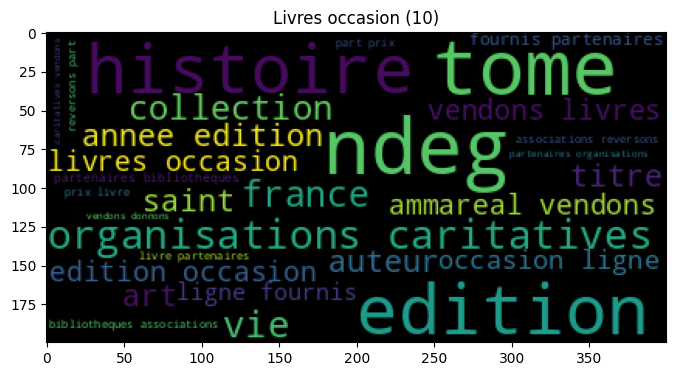

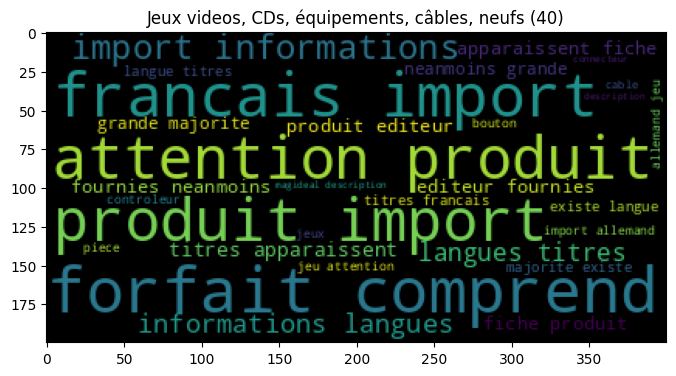

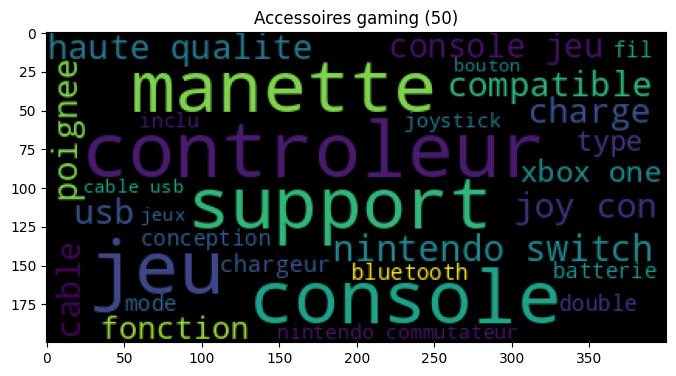

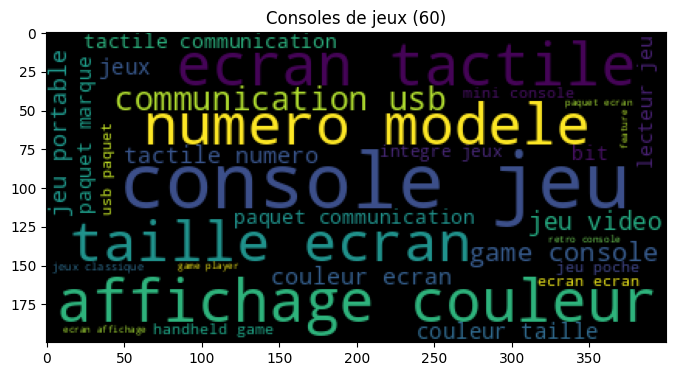

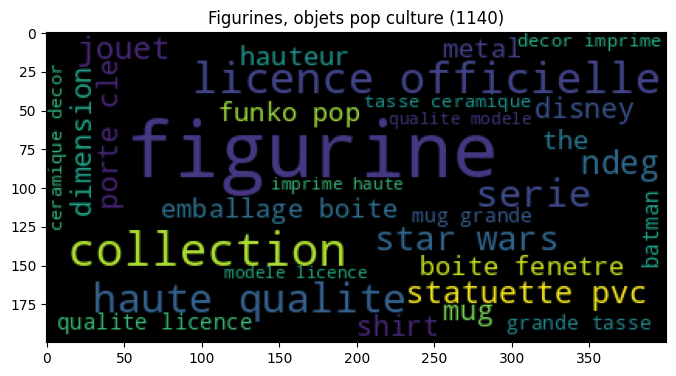

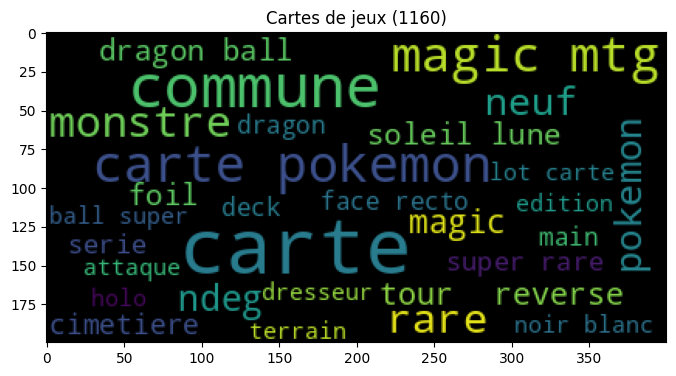

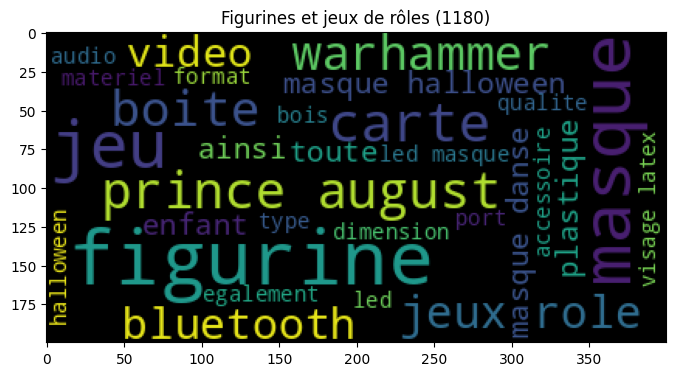

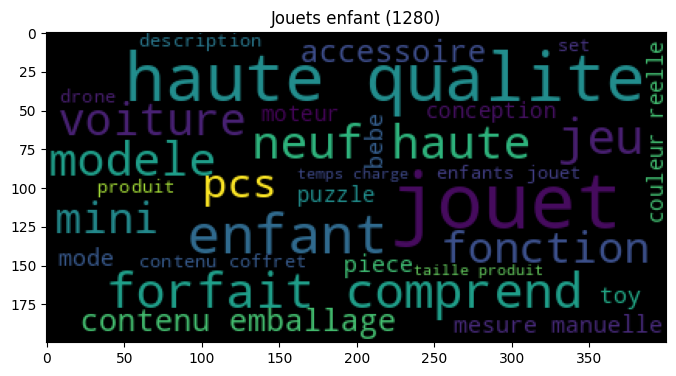

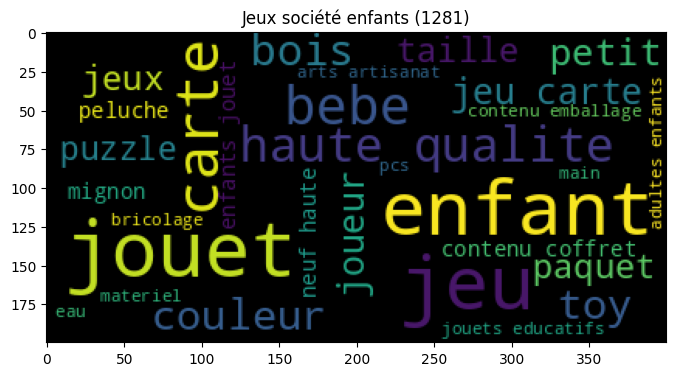

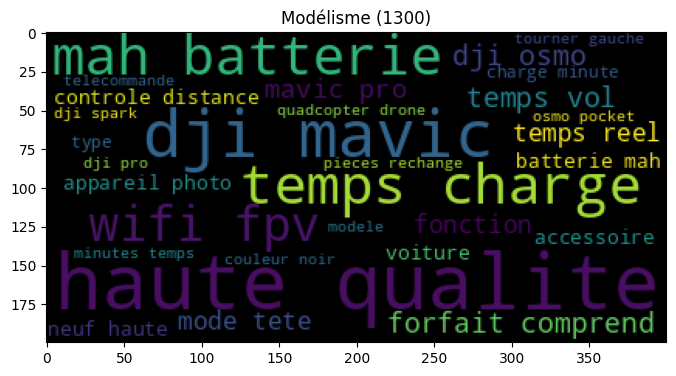

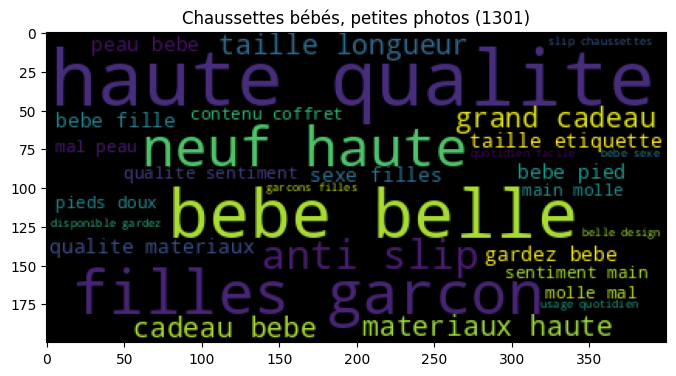

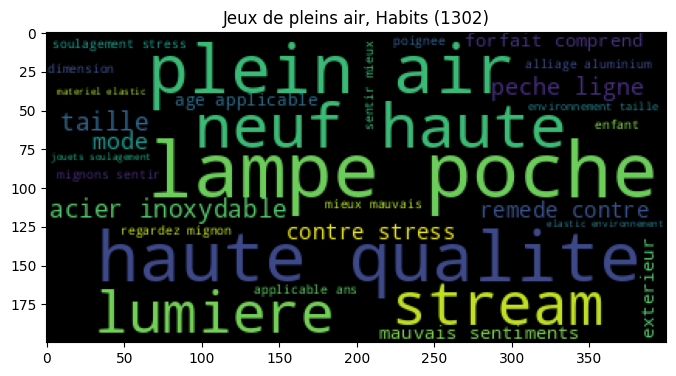

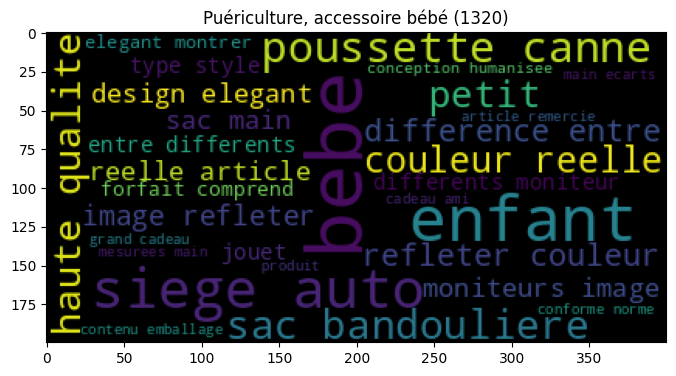

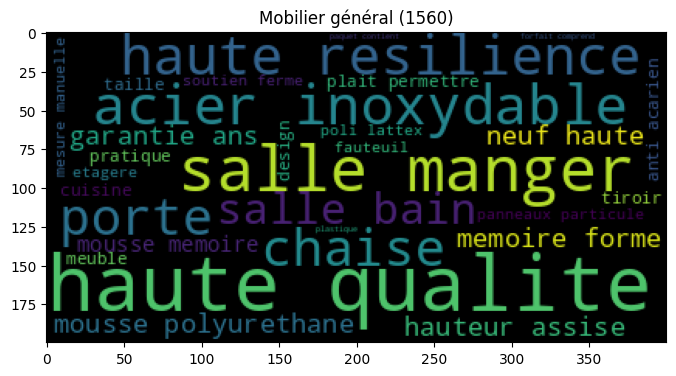

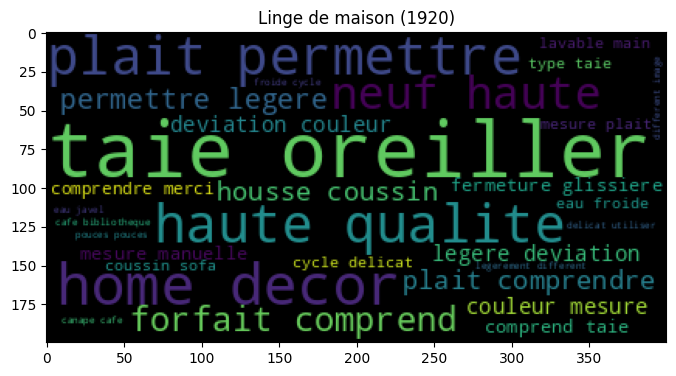

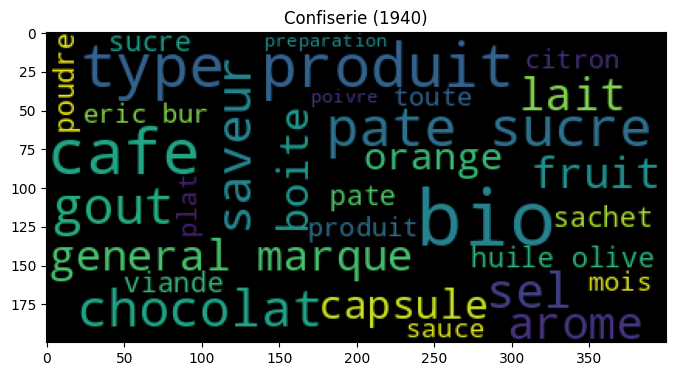

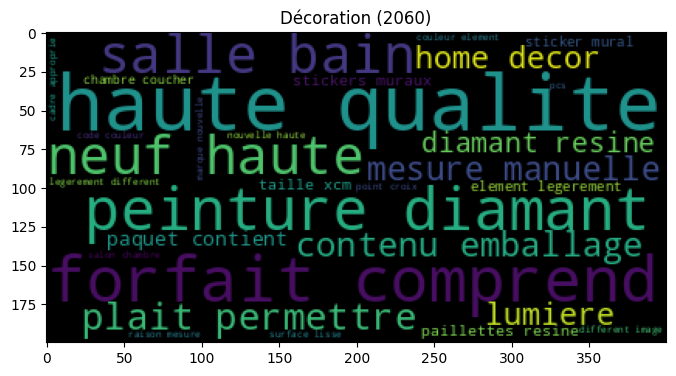

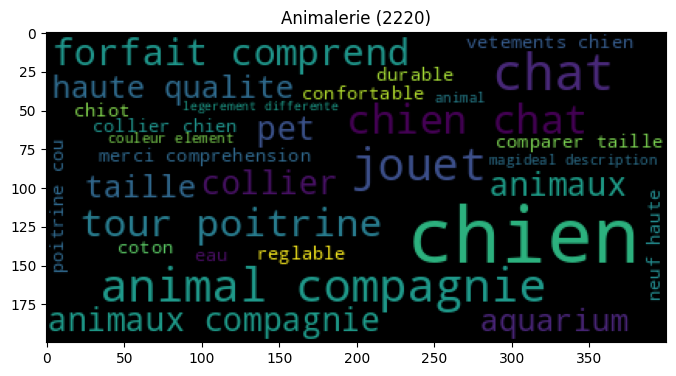

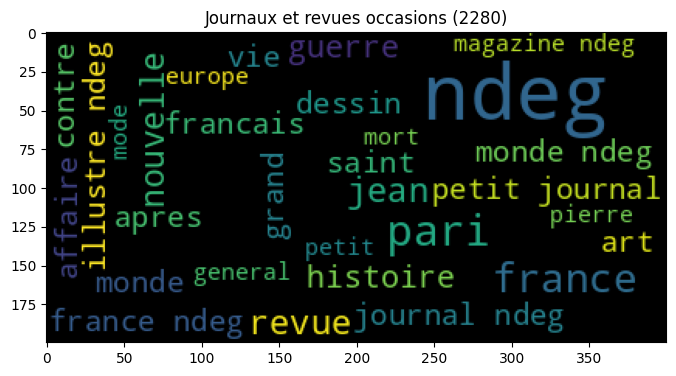

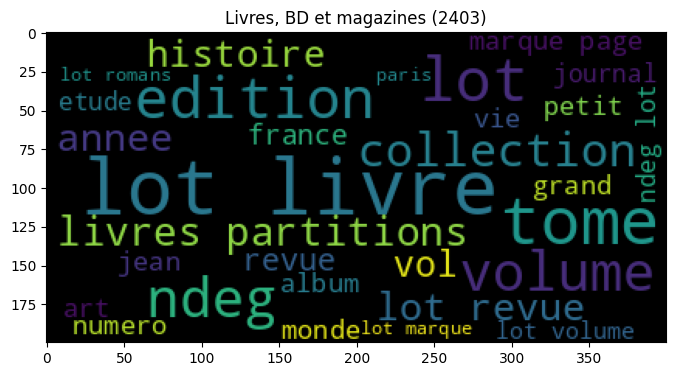

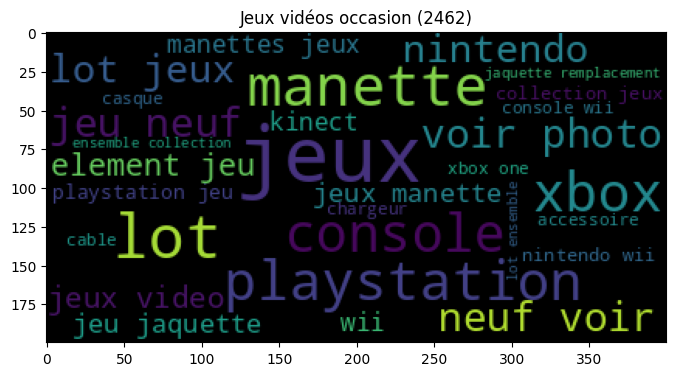

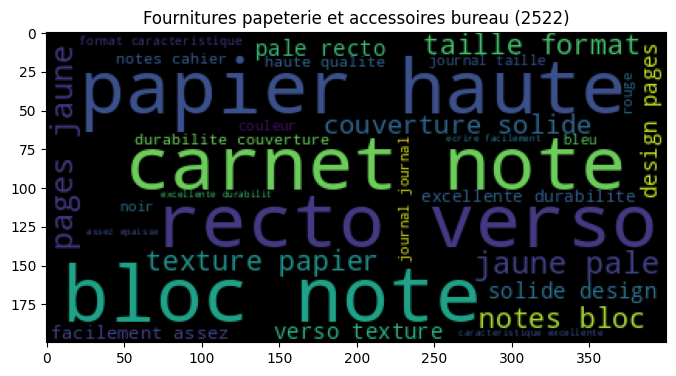

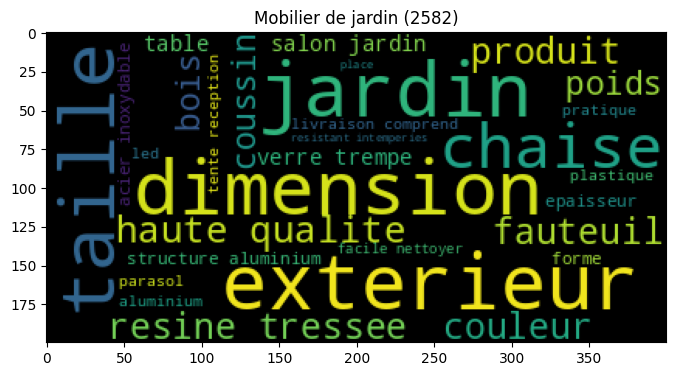

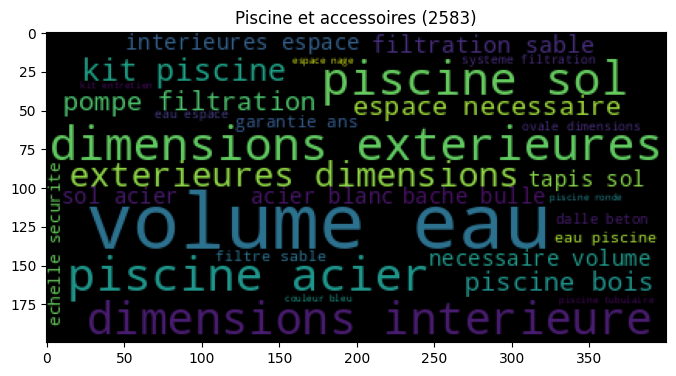

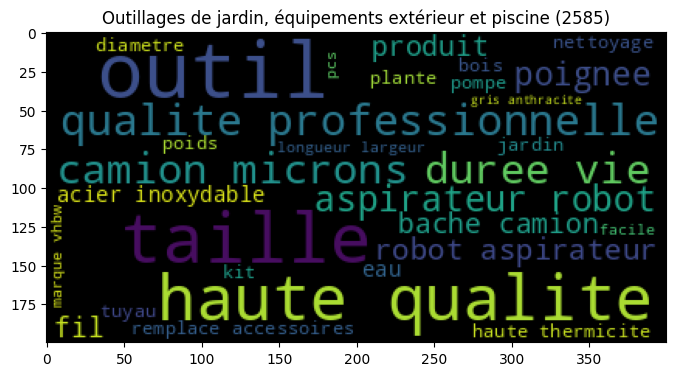

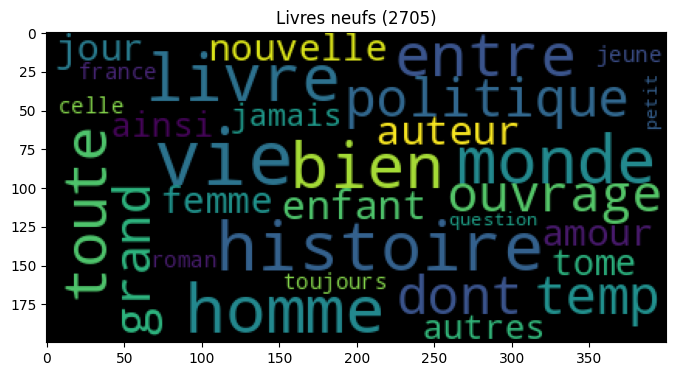

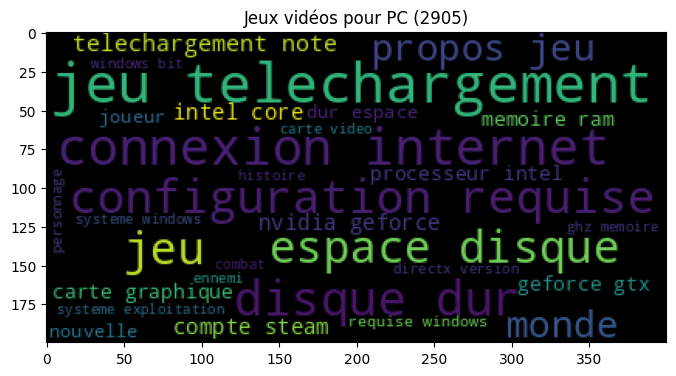

In [15]:
#Importer les packages nécessaires
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Définir le calque du nuage des mots
wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=50, random_state=42)

# Générer et afficher le nuage de mots
for index, row in df_grouped.iterrows():
    plt.figure(figsize= (8,6)) # Initialisation d'une figure
    wc.generate(row["text_clean"])           # "Calcul" du wordcloud
    plt.imshow(wc) # Affichage
    plt.title(row["category"]+" ("+str(row["prdtypecode"])+")")
    plt.show()

    

In [12]:
unidecode("Rustica N°41 Octobre")

'Rustica Ndeg41 Octobre'

In [40]:
df[df["prdtypecode"] == 2705].head(30) 
# livre d'occasion ndeg
# livres dont, entre, autres, jamais, ainsi, toujours, apres (Pronom,adj, adverve, préposition)

prdtypecode      category      token  count
750         2705  Livres neufs        vie    662
751         2705  Livres neufs      monde    464
752         2705  Livres neufs       bien    459
753         2705  Livres neufs      livre    448
754         2705  Livres neufs      entre    426
755         2705  Livres neufs   histoire    411
756         2705  Livres neufs      homme    383
757         2705  Livres neufs        ans    349
758         2705  Livres neufs       dont    318
759         2705  Livres neufs      temps    316
760         2705  Livres neufs    ouvrage    304
761         2705  Livres neufs     autres    280
762         2705  Livres neufs      jeune    259
763         2705  Livres neufs      amour    242
764         2705  Livres neufs     jamais    239
765         2705  Livres neufs     auteur    238
766         2705  Livres neufs      ainsi    237
767         2705  Livres neufs       tome    230
768         2705  Livres neufs   toujours    221
769         2705  Livres neufs     guerre    218
770         2705  Livres neufs        tre    218
771         2705  Livres neufs      grand    217
772         2705  Livres neufs     france    216
773         2705  Livres neufs     toutes    205
774         2705  Livres neufs      femme    203
775         2705  Livres neufs       pays    199
776         2705  Livres neufs      apres    199
777         2705  Livres neufs  politique    195
778         2705  Livres neufs      petit    189
779         2705  Livres neufs       jour    186

In [16]:
import spacy

nlp = spacy.load("fr_core_news_lg")  # Modèle NER spécialisé en français

text = "Le casque Sony est idéal pour Call of Duty."
#text = "Ce téléphone Samsung est inspiré du film The Matrix."
doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)  

Sony ORG
Call of Duty MISC


In [19]:
import spacy
nlp = spacy.load("xx_ent_wiki_sm")  # Modèle NER multilingue
#nlp = spacy.load("fr_core_news_lg")  # Modèle NER spécialisé en français

# ORG (Marques)
# PRODUCT (Produits, jeux vidéo, films)
# WORK_OF_ART (Films, livres)
#PERSON (Si pertinent, pour les créateurs de marque)

entities = ["ORG", "PRODUCT", "WORK_OF_ART", "MISC", "CATEGORY"]
#entities = ["ORG"]

org = set()

for text in df_grouped["text_clean"].head(1):
    #text = "Ce téléphone Samsung est inspiré du film The Matrix."
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in entities:
           # org.add(ent.text)
            print("(",ent.label_,")", ent.text)

display(org)

( ORG ) survenus europe
( MISC ) golfe guerre paix
( ORG ) lions
( MISC ) supervolcans
( MISC ) mach
( ORG ) institut national agronomique
( ORG ) sos
( MISC ) english
( MISC ) bataille empire
( MISC ) american
( ORG ) bla
( ORG ) dec
( ORG ) united states government
( ORG ) redigee division
( MISC ) deutsche
( MISC ) deutsche
( MISC ) british
( MISC ) french
( ORG ) front national eglise
( MISC ) congres archeologique
( MISC ) prix paix
( ORG ) france rugby
( ORG ) institut international agriculture rome
( ORG ) europe france
( MISC ) latin
( ORG ) politics europe
( ORG ) mercedes benz
( ORG ) institut national edition
( MISC ) star flash
( MISC ) aventures super amis gutenberg
( ORG ) parti communiste italien
( MISC ) latin
( MISC ) arabische
( MISC ) arabische
( MISC ) reponse
( MISC ) rdc odyssee
( MISC ) mac arthur
( MISC ) tazieff descend rappel puits
( ORG ) disney
( ORG ) ref
( MISC ) grand prix monaco demarquage
( MISC ) fortran
( MISC ) fortran
( MISC ) apl
( ORG ) porsche
( 

set()